In [1]:
# step2_semantic_representation.py
"""
ÉTAPE 2 : Représentation Sémantique — Version améliorée pour matching pondéré

Conforme au cahier des charges :
- Embeddings séparés par champ critique (fullName, bio, repo_descriptions, projects, etc.)
- Nettoyage multilingue (fr/en/ar) + gestion des caractères arabes
- Normalisation géographique (Maroc)
- Extraction des liens externes (LinkedIn/Twitter depuis GitHub)
- Préparation pour matching par paires (GitHub–LinkedIn, GitHub–Twitter, etc.)
- Support des noms complets (fullName) et descriptions techniques (repos, projets)

Sorties :
- Embeddings par champ (pour pondération à l’Étape 3)
- Métadonnées enrichies avec liens croisés
- Vecteur global optionnel (pour fallback)
"""

import json
import re
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer

# -----------------------------
# 2.1 : Nettoyage & Normalisation
# -----------------------------

def clean_text(text):
    """Nettoie le texte en conservant lettres latines (avec accents), arabes, chiffres, espaces."""
    if not isinstance(text, str):
        return ""
    # Supprimer URLs, emails
    text = re.sub(r'https?://\S+|www\.\S+|mailto:\S+', '', text, flags=re.IGNORECASE)
    # Garder lettres, chiffres, espaces, caractères arabes et accents FR
    text = re.sub(r'[^\w\s\u0600-\u06FFàâäéèêëïîôöùûüçÀÂÄÉÈÊËÏÎÔÖÙÛÜÇ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_location(loc):
    """Normalise vers 'morocco' si localisation marocaine."""
    if not loc:
        return "other"
    loc_lower = str(loc).lower().strip()
    country_variants = {"morocco", "maroc", "ma", "marocain", "marocaine"}
    city_variants = {
        "casablanca", "casa", "rabat", "mohammedia", "marrakech", "fes", "fez", "tanger",
        "agadir", "safi", "meknes", "oujda", "kenitra", "tetouan", "laayoune", "el jadida"
    }
    if any(var in loc_lower for var in country_variants) or any(city in loc_lower for city in city_variants):
        return "morocco"
    return "other"

def extract_external_link(external_links, platform):
    """Extrait le lien LinkedIn ou Twitter depuis GitHub."""
    if not isinstance(external_links, dict):
        return ""
    url = external_links.get(platform, "")
    if not url:
        return ""
    # Extraire le username LinkedIn (ex: https://linkedin.com/in/omarmhaimdat → omarmhaimdat)
    match = re.search(r'/in/([a-zA-Z0-9\-_]+)', url)
    return match.group(1).lower() if match else ""

# -----------------------------
# Chargement des profils par plateforme
# -----------------------------

def load_github_profiles(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    profiles = []
    for item in data:
        repo_descs = item.get("repo_descriptions", [])
        repo_text = " ".join([clean_text(desc) for desc in repo_descs]) if repo_descs else ""
        external_links = item.get("external_links", {})

        profiles.append({
            "platform": "github",
            "user_id": str(item.get("user_id", "")),
            "username": clean_text(item.get("username") or ""),
            "fullName": clean_text(item.get("name") or ""),
            "bio": clean_text(item.get("bio") or ""),
            "location": normalize_location(item.get("location")),
            "email": item.get("email") or None,
            "company": clean_text(item.get("company") or ""),
            "repo_descriptions": repo_text,
            "linkedin_username": extract_external_link(external_links, "linkedin"),
            "twitter_username": extract_external_link(external_links, "twitter")
        })
    return profiles

def load_twitter_profiles(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    profiles = []
    for item in data:
        username = clean_text(item.get("username") or "")
        full_name = clean_text(item.get("name") or username)
        bio = clean_text(item.get("bio") or "")
        # On ne peut pas déduire la localisation → on la laisse "other" sauf si déduit plus tard
        profiles.append({
            "platform": "twitter",
            "user_id": str(item.get("Twitter Username", "")),
            "username": username,
            "fullName": full_name,
            "bio": bio,
            "location": "other",  # sera mis à jour si fusionné
            "email": None,
            "company": "",
            "repo_descriptions": "",
            "linkedin_username": "",
            "twitter_username": username.lower()
        })
    return profiles

def load_linkedin_profiles(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    profiles = []
    for item in data:
        full_name = clean_text(item.get("full_name", "") or "")
        headline = clean_text(item.get("headline", "") or "")
        about = clean_text(item.get("about", "") or "")
        projects_text = ""
        projects = item.get("projects", [])
        if projects:
            project_descs = [clean_text(p.get("description", "")) for p in projects if p.get("description")]
            projects_text = " ".join(project_descs)

        profiles.append({
            "platform": "linkedin",
            "user_id": str(item.get("username", "")),
            "username": item.get("username", ""),
            "fullName": full_name,
            "bio": about,
            "headline": headline,
            "location": normalize_location(item.get("location")),  # <-- correction ici
            "email": item.get("email") or None,
            "company": clean_text(item.get("companyName", "") or ""),
            "repo_descriptions": projects_text,  # on réutilise ce champ pour les projets LinkedIn
            "linkedin_username": item.get("username", "").lower(),
            "twitter_username": ""
        })
    return profiles

# -----------------------------
# 2.2 : Encodage sémantique par champ
# -----------------------------

def main():
    print("🚀 ÉTAPE 2 : Représentation Sémantique (version matching pondéré)")
    print("   → Embeddings séparés par champ critique")
    print("   → Support FR/EN/AR + ciblage Maroc")
    print("   → Extraction des liens externes (LinkedIn/Twitter)")

    data_dir = Path("data")
    output_dir = Path("output")
    output_dir.mkdir(exist_ok=True)

    # Chargement
    github_profiles = load_github_profiles(data_dir / "github.json")
    twitter_profiles = load_twitter_profiles(data_dir / "twitter.json")
    linkedin_profiles = load_linkedin_profiles(data_dir / "linkedin.json")
    all_profiles = github_profiles + twitter_profiles + linkedin_profiles

    print(f"✅ {len(all_profiles)} profils chargés.")

    # Modèle multilingue
    print("🧠 Chargement du modèle 'paraphrase-multilingual-MiniLM-L12-v2'...")
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    # Champs à encoder séparément
    fields_to_embed = ["fullName", "username", "bio", "repo_descriptions", "headline"]

    # Initialisation des listes
    embeddings_dict = {field: [] for field in fields_to_embed}
    embeddings_dict["global"] = []

    # Métadonnées
    serializable_profiles = []

    for idx, profile in enumerate(all_profiles):
        # Encoder chaque champ
        for field in fields_to_embed:
            text = profile.get(field, "")
            emb = model.encode(text, convert_to_numpy=True)
            embeddings_dict[field].append(emb)

        # Vecteur global (fallback)
        global_text = " ".join([
            profile.get("fullName", ""),
            profile.get("bio", ""),
            profile.get("headline", ""),
            profile.get("repo_descriptions", ""),
            profile.get("company", "")
        ])
        global_emb = model.encode(global_text, convert_to_numpy=True)
        embeddings_dict["global"].append(global_emb)

        # Ajouter index et garder profil lisible
        clean_profile = {
            k: (str(v) if isinstance(v, (list, dict, np.ndarray)) else v)
            for k, v in profile.items()
        }
        clean_profile["vector_index"] = idx
        serializable_profiles.append(clean_profile)

    # Sauvegarde des embeddings
    for field, embs in embeddings_dict.items():
        np.save(output_dir / f"{field}_embeddings.npy", np.array(embs))

    # Sauvegarde des métadonnées
    with open(output_dir / "profiles_metadata.json", "w", encoding="utf-8") as f:
        json.dump(serializable_profiles, f, indent=2, ensure_ascii=False)

    print(f"✅ Embeddings sauvegardés pour : {list(embeddings_dict.keys())}")
    print("✅ Métadonnées sauvegardées dans 'output/profiles_metadata.json'")
    print("➡️ Prêt pour l’ÉTAPE 3 : Matching pondéré par paires.")

if __name__ == "__main__":
    main()

🚀 ÉTAPE 2 : Représentation Sémantique (version matching pondéré)
   → Embeddings séparés par champ critique
   → Support FR/EN/AR + ciblage Maroc
   → Extraction des liens externes (LinkedIn/Twitter)
✅ 11399 profils chargés.
🧠 Chargement du modèle 'paraphrase-multilingual-MiniLM-L12-v2'...
✅ Embeddings sauvegardés pour : ['fullName', 'username', 'bio', 'repo_descriptions', 'headline', 'global']
✅ Métadonnées sauvegardées dans 'output/profiles_metadata.json'
➡️ Prêt pour l’ÉTAPE 3 : Matching pondéré par paires.


/tmp/ipykernel_18027/1719285617.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_counts.index, y=platform_counts.values, palette="viridis")


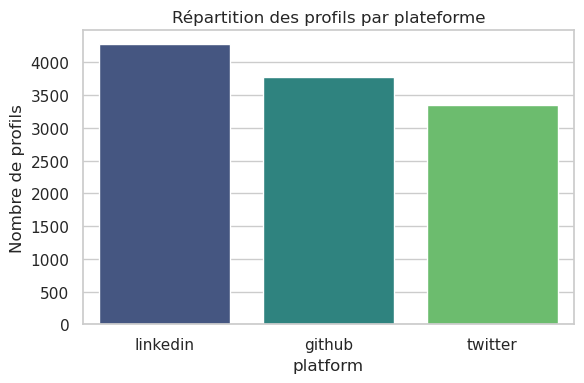

/tmp/ipykernel_18027/1719285617.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(coverage.keys()), y=list(coverage.values()), palette="rocket")


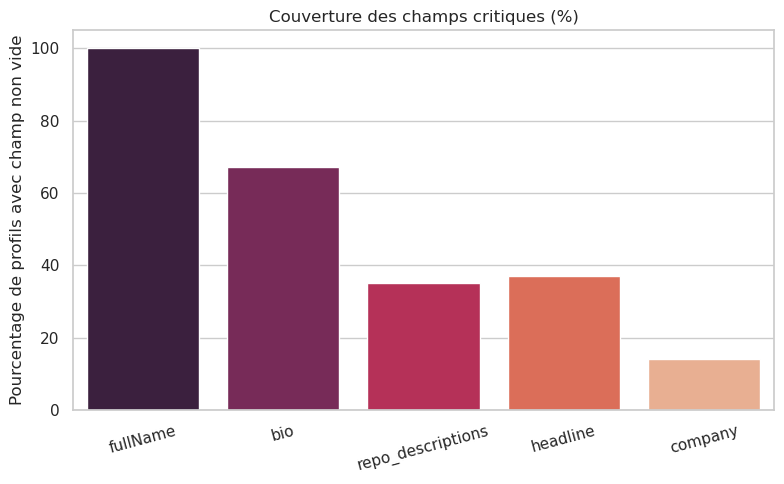

/tmp/ipykernel_18027/1719285617.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(external_links.keys()), y=list(external_links.values()), palette="muted")


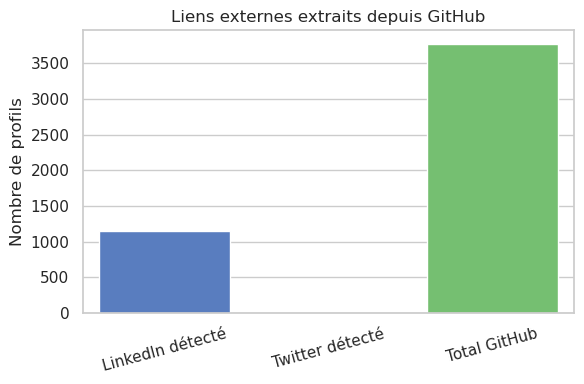


📊 Statistiques de longueur des textes (caractères) :
                    mean  median  non_empty_mean
fullName            13.8    14.0            13.8
bio                156.4    44.0           233.0
repo_descriptions  337.6     0.0           961.5
headline            21.2     0.0            57.1

✅ Résumé global :
- Total profils : 11399
- GitHub : 3770
- LinkedIn : 4276
- Twitter : 3353
- Profils marocains : 4416 (38.7%)
- Liens LinkedIn détectés (depuis GitHub) : 1146
- Liens Twitter détectés (depuis GitHub) : 0


In [2]:
# step2_stats_viz.py
"""
Visualisation et statistiques descriptives après ÉTAPE 2
- Répartition plateforme
- Couverture des champs
- Localisation
- Liens externes détectés
- Longueur moyenne des textes (proxy de richesse sémantique)
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

sns.set(style="whitegrid")
output_dir = Path("output")

# Charger les métadonnées
with open(output_dir / "profiles_metadata.json", "r", encoding="utf-8") as f:
    profiles = json.load(f)

df = pd.DataFrame(profiles)

# 1. Répartition par plateforme
plt.figure(figsize=(6, 4))
platform_counts = df['platform'].value_counts()
sns.barplot(x=platform_counts.index, y=platform_counts.values, palette="viridis")
plt.title("Répartition des profils par plateforme")
plt.ylabel("Nombre de profils")
plt.tight_layout()
plt.savefig(output_dir / "platform_distribution.png")
plt.show()

# 2. Couverture des champs critiques
fields = ["fullName", "bio", "repo_descriptions", "headline", "company"]
coverage = {}
for field in fields:
    non_empty = df[field].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0).sum()
    coverage[field] = non_empty / len(df) * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=list(coverage.keys()), y=list(coverage.values()), palette="rocket")
plt.title("Couverture des champs critiques (%)")
plt.ylabel("Pourcentage de profils avec champ non vide")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(output_dir / "field_coverage.png")
plt.show()


# 3. Liens externes détectés (depuis GitHub uniquement)
github_df = df[df['platform'] == 'github']
linkedin_found = github_df['linkedin_username'].apply(lambda x: bool(x)).sum()
twitter_found = github_df['twitter_username'].apply(lambda x: bool(x)).sum()

external_links = {
    "LinkedIn détecté": linkedin_found,
    "Twitter détecté": twitter_found,
    "Total GitHub": len(github_df)
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(external_links.keys()), y=list(external_links.values()), palette="muted")
plt.title("Liens externes extraits depuis GitHub")
plt.ylabel("Nombre de profils")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(output_dir / "external_links.png")
plt.show()

# 4. Longueur moyenne des textes (proxy de richesse sémantique)
text_fields = ["fullName", "bio", "repo_descriptions", "headline"]
length_stats = {}
for field in text_fields:
    lengths = df[field].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    length_stats[field] = {
        "mean": lengths.mean(),
        "median": lengths.median(),
        "non_empty_mean": lengths[lengths > 0].mean() if (lengths > 0).any() else 0
    }

length_df = pd.DataFrame(length_stats).T
print("\n📊 Statistiques de longueur des textes (caractères) :")
print(length_df.round(1))

# Optionnel : sauvegarder les stats
length_df.to_csv(output_dir / "text_length_stats.csv")

# Résumé global
print(f"\n✅ Résumé global :")
print(f"- Total profils : {len(df)}")
print(f"- GitHub : {len(df[df['platform']=='github'])}")
print(f"- LinkedIn : {len(df[df['platform']=='linkedin'])}")
print(f"- Twitter : {len(df[df['platform']=='twitter'])}")
print(f"- Profils marocains : {len(df[df['location']=='morocco'])} ({100*len(df[df['location']=='morocco'])/len(df):.1f}%)")
print(f"- Liens LinkedIn détectés (depuis GitHub) : {linkedin_found}")
print(f"- Liens Twitter détectés (depuis GitHub) : {twitter_found}")